IA & Data science -- 2020-2021
--------


## Données

Les données vous sont fournies sur le moodle. 
Ces données sont fournies sur Kaggle, ce sont les données *Google Play Store Apps* accessibles à l'adresse https://www.kaggle.com/lava18/google-play-store-apps.

Il est indispensable de lire en détail la page Kaggle pour comprendre à quoi ces données correspondent.

Le compte-rendu a fournir le jour de la dernière séance de TDTME de votre groupe doit comporter:
- un fichier PDF qui correspond à un poster sur lequel sont expliqués les différents problèmes traités, la façon dont ils ont été traités, et les résultats obtenus.
- un notebook par problème traité, vous pouvez traiter autant de problème que vous le souhaitez. Le problème étudié doit être décrit précisément et vous devez impérativement suivre le format ci-dessous.

Bien entendu, le tout sera mis dans un fichier archive (tar.gz ou zip exclusivement) et déposé sur le site Moodle.


Format à suivre:

 # **<font color="RED"> Les importation </font>**

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import scipy.stats as stats #  une librairie des fonctions statiques et probas https://docs.scipy.org/doc/scipy/reference/stats.html
import seaborn as sns # une librairie basé sur matplotlib pour les visualisations: https://seaborn.pydata.org/tutorial.html
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#import plotly.figure_factory as ff
#import cufflinks as cf

import warnings
warnings.filterwarnings('ignore')

In [22]:
import sys 
sys.path.append("../src")
from iads import utils
from iads import clustering

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <font color="RED">  Variables globals  </font> 
le chemain vers les données 

In [23]:
DATA_DIR = "../data" # le chamin vers la base de donnée

#  **<font color="RED"> Load Datasets </font>**

In [24]:
googleplaystore = pd.read_csv(f'{DATA_DIR}/googleplaystore.csv')
#reviews = pd.read_csv(f'{DATA_DIR}/googleplaystore_user_reviews.csv') pour l'instant on travail que avec la dataset: googleplaystore 

# **<font color="RED">  Data Processing: </font>** 

In [25]:

def func(i):
    """
    une fonction qui va nous aider dans le processus du data cleaning 
    """
    try:
        i = i.replace("+", '') 
        i = i.replace(",", '')
        
        if 'm' in i:
            i = i.replace('m', '')
            d = float(i)*10**6
        
        elif 'k' in i:
            i = i.replace('k', '')
            d = float(i)*10**3
        else:
            d = float(i)*10**3
        
        return d
    except Exception as e :
        return i
    

googleplaystore.drop_duplicates(subset='App', inplace=True) # supression des ligne dupliquées 
googleplaystore = googleplaystore[googleplaystore['Android Ver'] != np.nan]
googleplaystore = googleplaystore[googleplaystore['Android Ver'] != 'NaN']
googleplaystore = googleplaystore[googleplaystore['Installs'] != 'Free']
googleplaystore = googleplaystore[googleplaystore['Installs'] != 'Paid']
googleplaystore = googleplaystore[googleplaystore['Category']!='1.9']

googleplaystore['Rating'] = googleplaystore.Rating.fillna(0) 
googleplaystore['Reviews'] = googleplaystore['Reviews'].apply(lambda x: int(x))


googleplaystore['Size'] = googleplaystore['Size'].str.replace('Varies with device', 'NaN')
googleplaystore['Size'] = googleplaystore['Size'].str.replace('M', '')
googleplaystore['Size'] = googleplaystore['Size'].str.replace(',', '')
googleplaystore['Size'] = googleplaystore['Size'].str.replace('+', '')
googleplaystore['Size'] = googleplaystore['Size'].apply(lambda x: float(str(x).replace('k', '')) / (10**(-3)))
googleplaystore['Size'] = googleplaystore['Size'].apply(lambda x: float(x))
googleplaystore['Size'] = googleplaystore['Size'].fillna(googleplaystore['Size'].mean())

googleplaystore['Installs'] = googleplaystore['Installs'].apply(lambda x: x.replace('+', ''))
googleplaystore['Installs'] = googleplaystore['Installs'].apply(lambda x: x.replace(',', ''))
googleplaystore['Installs'] = googleplaystore['Installs'].apply(lambda x: int(x))
googleplaystore['Installs'] = googleplaystore['Installs'].apply(lambda x: float(x))


googleplaystore['Price'] = googleplaystore['Price'].apply(lambda x: str(x).replace('$', ''))
googleplaystore['Price'] = googleplaystore['Price'].apply(lambda x: float(x))


id2categorie = dict(enumerate(googleplaystore.Category.unique()))
categorie2id = {category:i for i, category in id2categorie.items()}
googleplaystore['Category'] = googleplaystore.Category.replace(categorie2id)


id2Type = dict(enumerate(googleplaystore.Type.unique()))
type2id = {typee:i for i, typee in id2Type.items()}
googleplaystore['Type'] = googleplaystore.Type.replace(type2id)


id2Genres = dict(enumerate(googleplaystore.Genres.unique()))
Genres2id = {Genrese:i for i, Genrese in id2Genres.items()}
googleplaystore['Genres'] = googleplaystore.Genres.replace(Genres2id)

id2CR = dict(enumerate(googleplaystore['Content Rating'].unique()))
CR2id = {CRe:i for i, CRe in id2CR.items()}
googleplaystore['Content Rating'] = googleplaystore['Content Rating'].replace(CR2id)



### Standardize the Data

Les données on va les normalizer avec les deux methodes:

- Standard Scalar $z = \frac{x_{i}-\mu(x)}{\sigma(x)}$ pour la PCA
- MinMax Scalar $z = \frac{x-\min (x)}{\max (x)-\min (x)}$ pour le clustering

In [26]:
data = googleplaystore[['Category','Rating','Reviews','Size','Installs','Type','Price','Content Rating','Genres']].values

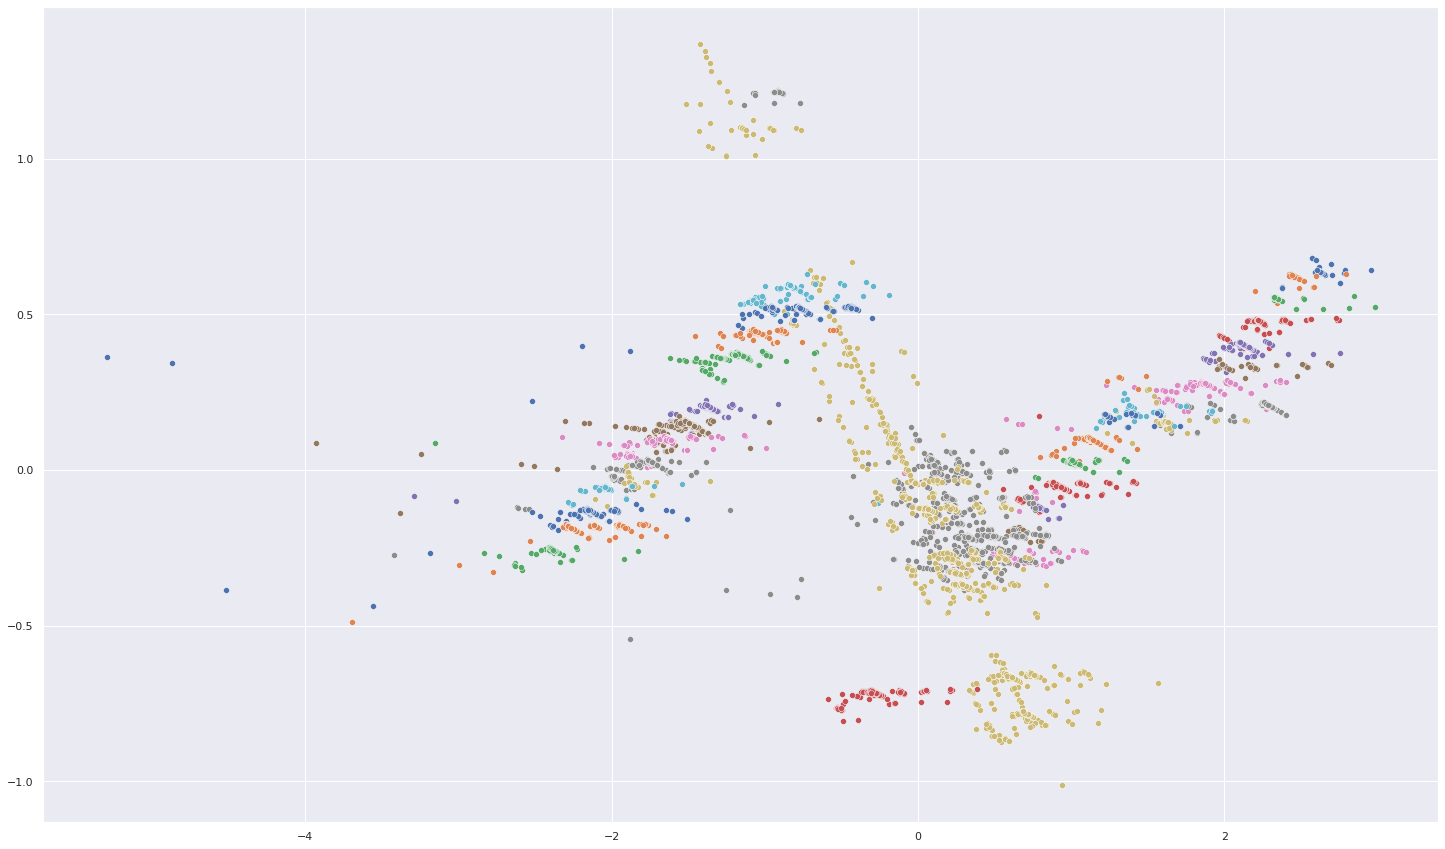

In [27]:
pca = utils.pca(data, n_components=2)



for categorie in googleplaystore.Category.unique():
    sns.scatterplot(pca[(googleplaystore['Category']==categorie).values, 0],
                   pca[(googleplaystore['Category']==categorie).values, 1],legend="full")


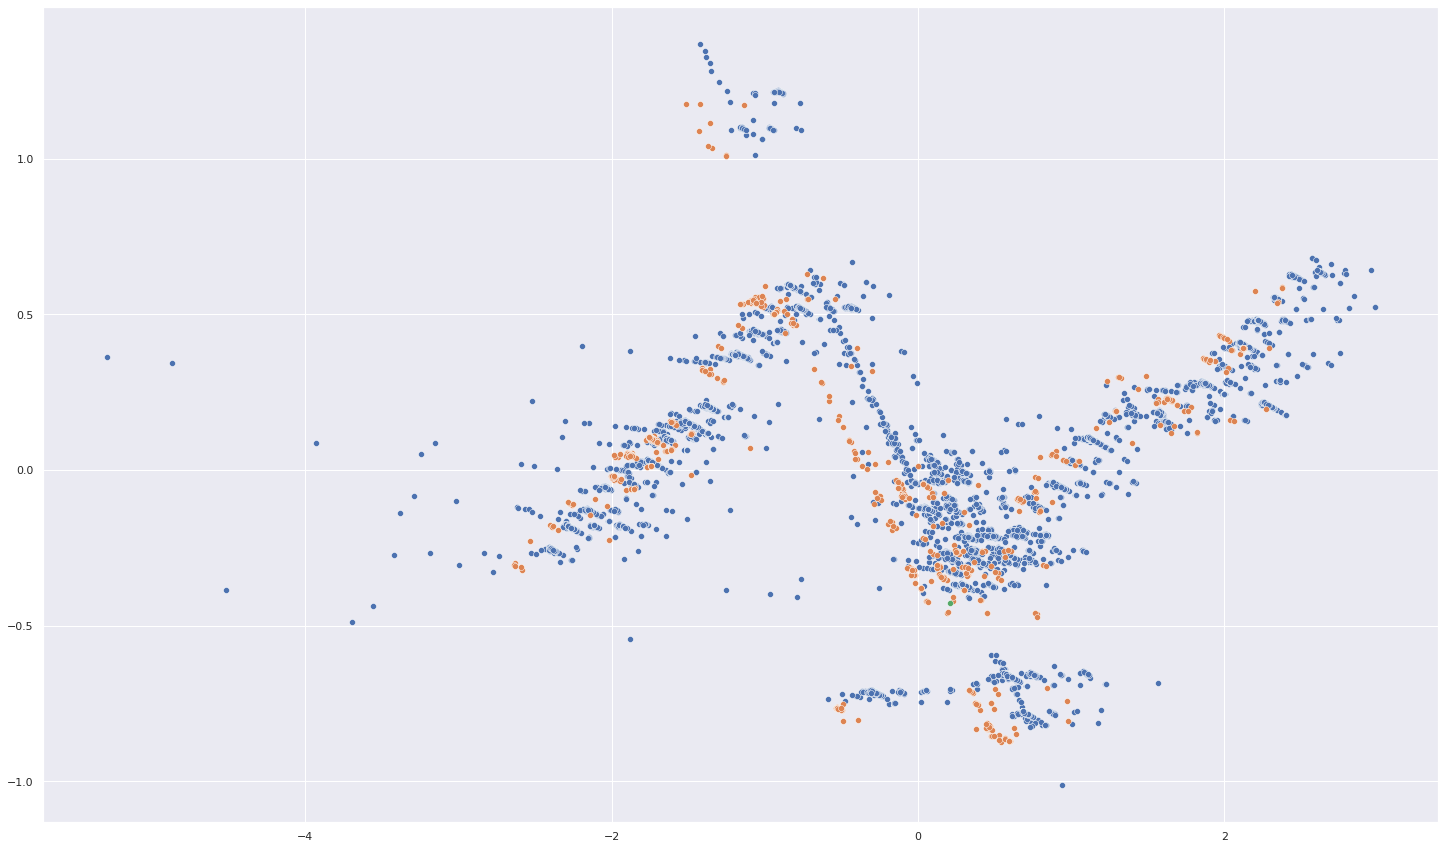

In [29]:
for categorie in googleplaystore.Type.unique():
    sns_plot=sns.scatterplot(pca[(googleplaystore['Type']==categorie).values, 0],
                   pca[(googleplaystore['Type']==categorie).values, 1],
    legend="full")
    


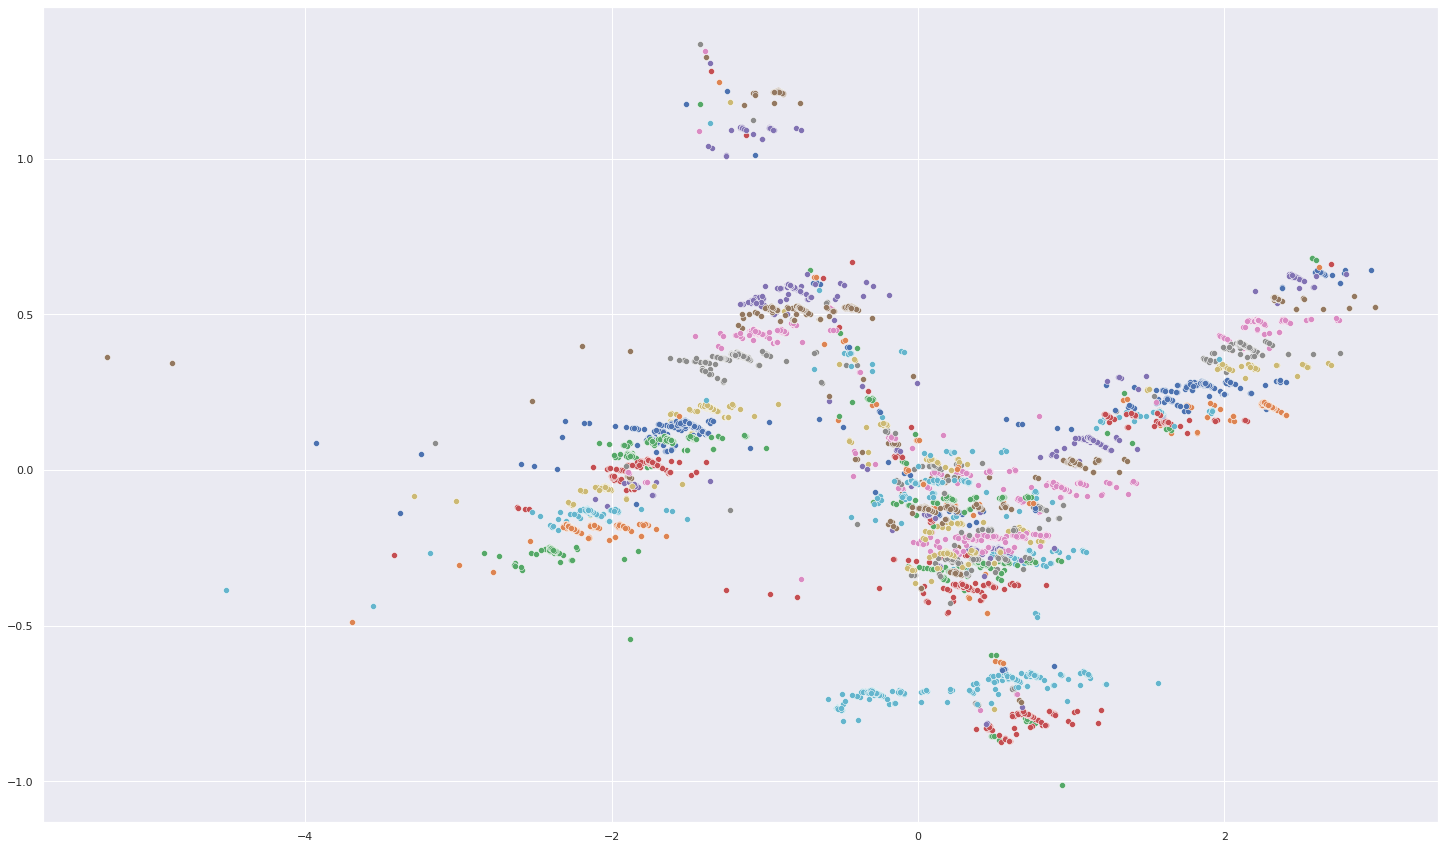

In [30]:
for categorie in googleplaystore.Genres.unique():
    sns_plot=sns.scatterplot(pca[(googleplaystore['Genres']==categorie).values, 0],
                   pca[(googleplaystore['Genres']==categorie).values, 1],
    legend="full")

In [31]:
centroides, matrix = clustering.kmoyennes(
    k=10, 
    X=data, 
    epsilon=0.3, 
    iter_max=int(1e3)
)

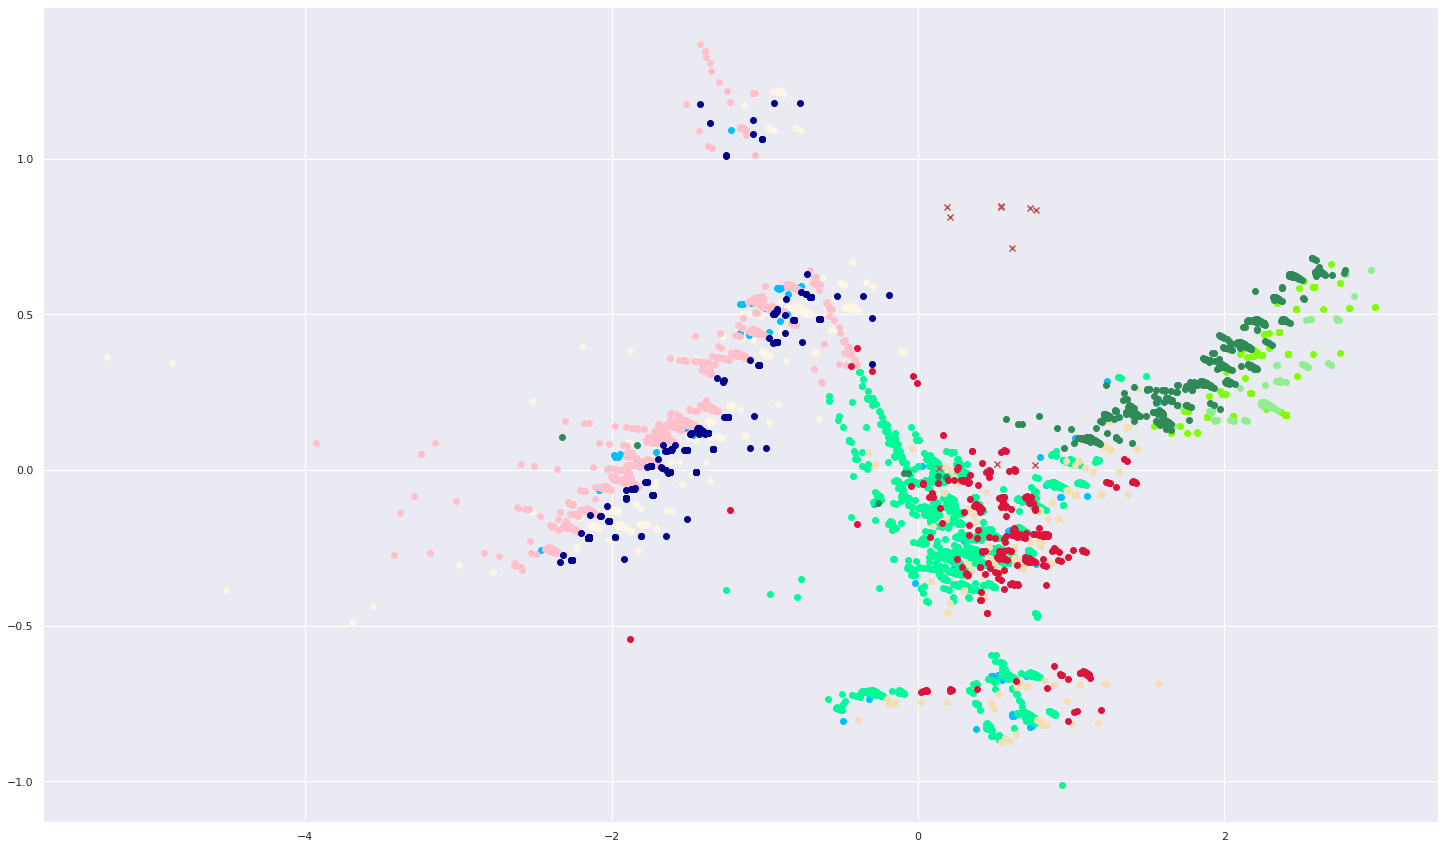

In [33]:
clustering.affiche_resultat(pca, centroides, matrix)

In [13]:
# CAAAA MARCHE PAS VRAIMENT 



from tqdm import tqdm
def calculate_WSS(data, num_k):
    sse = []
    clustering_res= []
    for k in tqdm(range(2, num_k+2), total=num_k):
        centroides, matrix = clustering.kmoyennes(
                                k=k, 
                                X=data, 
                                epsilon=0.01, 
                                iter_max=int(1e2)
                            )
        curr_sse = 0
        clustering_res.append((centroides, matrix))
        for c_name, index in matrix.items():
            curr_sse = clustering.dist_vect(data[index], centroides[c_name]).sum()

        sse.append(curr_sse)
    return sse, clustering_res

In [14]:
r, clustering_res = calculate_WSS(data, 100)

100%|██████████| 100/100 [45:45<00:00, 27.45s/it]


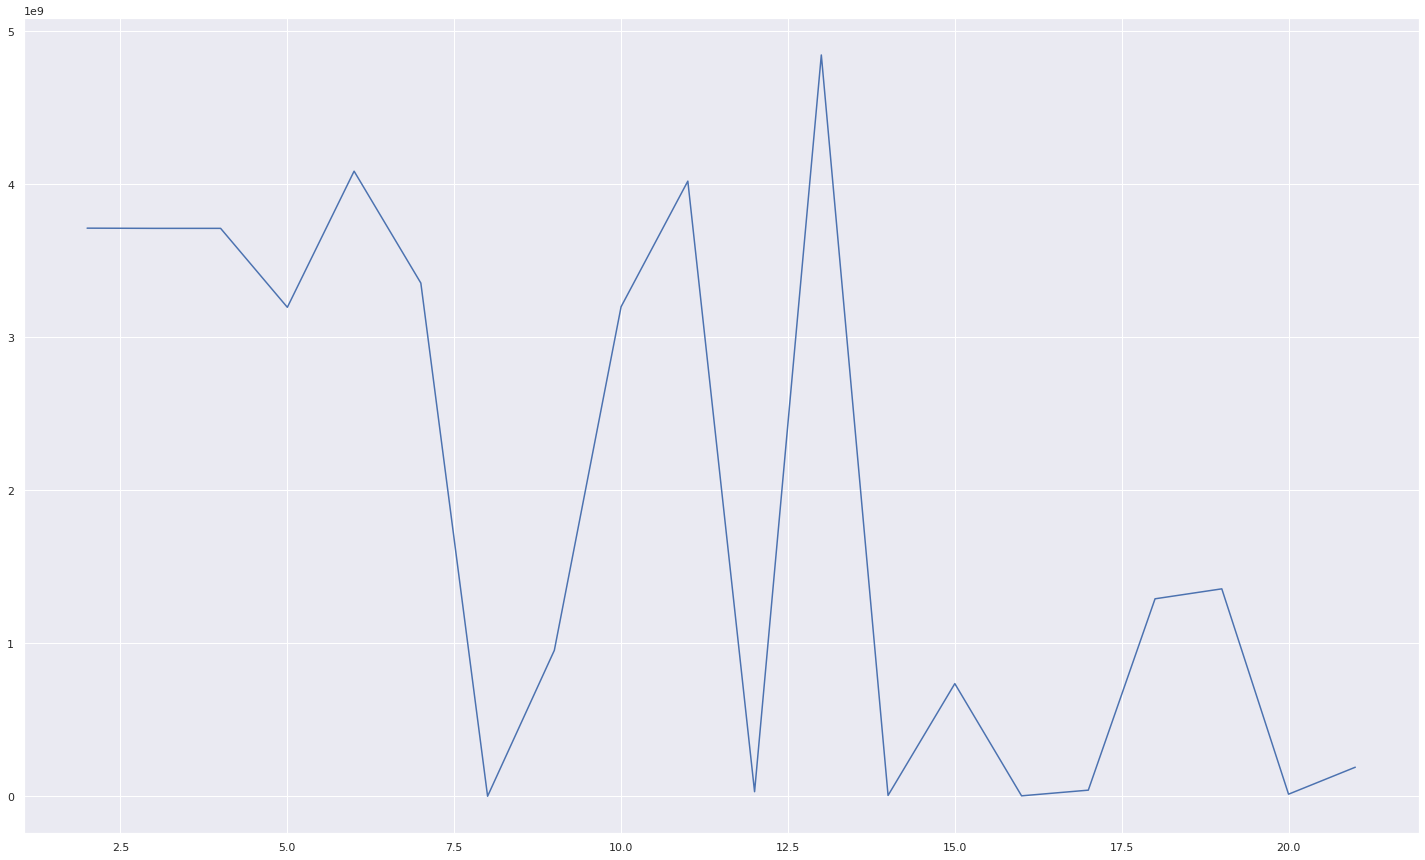

In [20]:
plt.plot(range(2, 22), r[:20])

In [ ]:
clustering.affiche_resultat(pca, centroides, matrix)

In [16]:
import pickle
filehandler = open(b"../clustering_wss_results.obj","wb")
pickle.dump(r,filehandler)


In [17]:
ls ../

clustering_results.obj  clustering_wss_results.obj  data/  notebooks/  src/
